In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style="white", font_scale=1.2)
plt.rcParams["font.family"] = ["Inter"]

In [3]:
savedir = "figures"
if not os.path.exists(savedir):
    os.mkdir(savedir)

In [4]:
filepath = "betas.h5ad"

In [5]:
adata = sc.read(filepath)
adata.obs["group"].replace({0: "Low", 1: "High"}, inplace=True)

In [6]:
df = adata.to_df()
df["group"] = adata.obs["group"].tolist()
agg = df.groupby("group").agg("mean")

In [7]:
adata_cl = adata[adata.obs["Source"]=="Clinical cohort_combined treatment"]

In [8]:
adata_cl.shape

(363, 423669)

In [9]:
from sklearn.impute import SimpleImputer

In [10]:
imputer = SimpleImputer(strategy='mean')
adata.X = imputer.fit_transform(adata.to_df())

In [11]:
# adata_cl.to_df().to_csv("clinical_cohort_betas_all.csv")
# adata_cl.obs.to_csv("clinical_cohort_metadata_all.csv")
# already ran

-----

In [12]:
cpgs = pd.read_csv("cpg_dmpfinder_all.csv", index_col=0)
cpgs = cpgs[cpgs.qval<0.05]

In [13]:
scores = agg.copy()
scores.loc["diff"] = scores.loc["High"]-scores.loc["Low"]

In [14]:
cpgs["deltaBeta"] = scores.loc["diff", cpgs.index].tolist()

In [15]:
cpgs_high = cpgs[cpgs.deltaBeta>=0.15].index.tolist()
cpgs_low = cpgs[cpgs.deltaBeta<=-0.15].index.tolist()

In [16]:
cpgs.loc[cpgs_low+cpgs_high].to_csv("diff_CpG_all.csv")

In [17]:
cpgs = pd.read_csv("diff_CpG_all.csv", index_col=0).index

In [18]:
len(cpgs)

1289

In [19]:
adata[:, cpgs_high].var.to_csv("high_manifest_all.csv")
adata[:, cpgs_low].var.to_csv("low_manifest_all.csv")

In [20]:
adata.shape

(1447, 423669)

In [21]:
adata.to_df().T.shape

(423669, 1447)

In [22]:
sub = adata[:, cpgs_low+cpgs_high]

In [23]:
sub.shape

(1447, 1289)

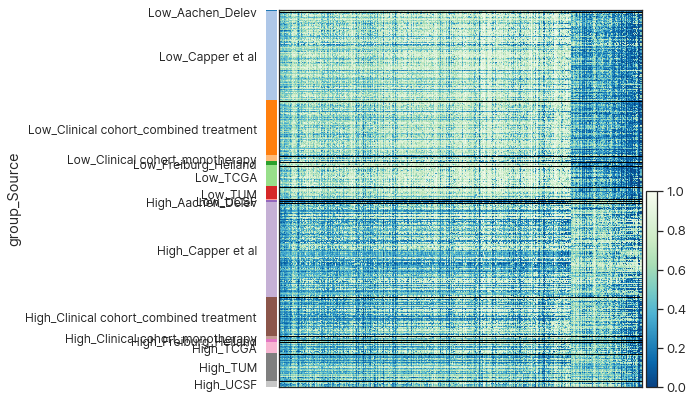

In [24]:
sub.layers["scaled"] = sc.pp.scale(sub, copy=True).X
ax = sc.pl.heatmap(sub, var_names=sub.var_names, groupby=["group", "Source", ], cmap="GnBu_r",  vmin=0, vmax=1, figsize=(7,7),
                  show=False)
plt.savefig(os.path.join(savedir, "heatmap_all_samples_noNorma_allCpG.pdf"), bbox_inches="tight")

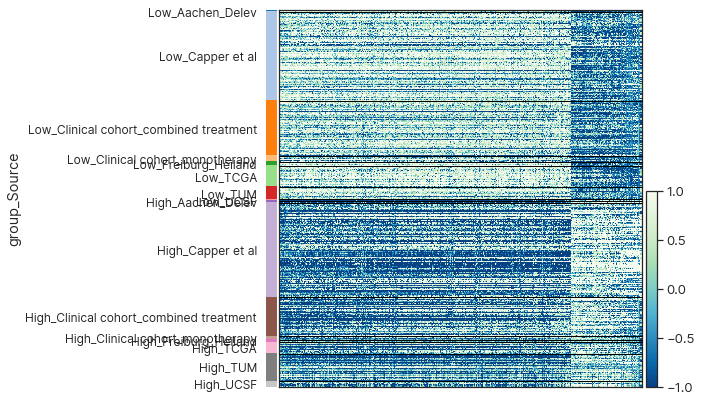

In [25]:
sub.layers["scaled"] = sc.pp.scale(sub, copy=True).X
ax = sc.pl.heatmap(sub, var_names=sub.var_names, groupby=["group", "Source", ], cmap="GnBu_r", layer="scaled", vmin=-1, vmax=1, figsize=(7,7),
                  show=False)
plt.savefig(os.path.join(savedir, "heatmap_all_samples_allCpG.pdf"), bbox_inches="tight")

# Train and test logistic regression

In [26]:
train = sub[sub.obs["Source"]=="Clinical cohort_combined treatment"]
test = sub[sub.obs["Source"]!="Clinical cohort_combined treatment"]

In [27]:
train.obs["group"].replace({"Low": 0, "High":1}, inplace=True)
test.obs["group"].replace({"Low": 0, "High":1}, inplace=True)


In [28]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

In [29]:
clf = LogisticRegressionCV(random_state=42, max_iter=10000)
# clf = CalibratedClassifierCV()
clf.fit(train.X, train.obs["group"])

LogisticRegressionCV(max_iter=10000, random_state=42)

In [30]:
import joblib
joblib.dump(clf, "logregCV_allCpG.pkl")

['logregCV_allCpG.pkl']

In [31]:
clf.classes_

array([0, 1])

In [32]:
test.obs["prediction"] = clf.predict(test.X)
test.obs["prediction_score"] = clf.predict_proba(test.X).max(1)
test.obs["prediction_score_high"] = clf.predict_proba(test.X)[:,1]
test.obs["prediction_score_low"] = clf.predict_proba(test.X)[:,0]

/tmp/ipykernel_2916703/2328724188.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test.obs["prediction"] = clf.predict(test.X)


In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [34]:
clf_report = classification_report(test.obs.group, test.obs.prediction)
print(clf_report)

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       518
           1       0.90      0.79      0.84       566

    accuracy                           0.85      1084
   macro avg       0.85      0.85      0.84      1084
weighted avg       0.85      0.85      0.84      1084



In [35]:
from matplotlib.colors import ListedColormap

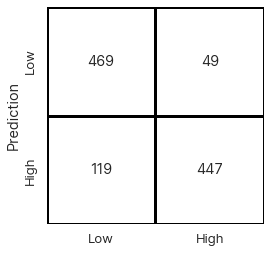

In [36]:
cm = confusion_matrix(test.obs.group, test.obs.prediction)
df_cm = pd.DataFrame(cm, index=["Low", "High"], columns=["Low", "High"])
sns.heatmap(df_cm, annot=True, fmt="d", cmap=ListedColormap(['white']), cbar=False, square=True, linecolor="black", linewidths=1.1)
plt.ylabel("Prediction")
plt.savefig(os.path.join(savedir, "confusion_matrix_allCpG.pdf"), bbox_inches="tight")

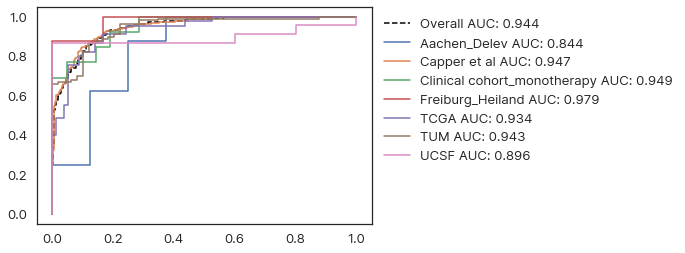

In [37]:
fpr, tpr, thresholds = roc_curve(test.obs.group, test.obs.prediction_score_high, pos_label=1)
auc = roc_auc_score(test.obs.group, test.obs.prediction_score_high)
plt.plot(fpr, tpr, linestyle='--', label='Overall AUC: %.3f' % auc, color="black")

for source in sorted(test.obs.Source.unique()):
    test_source = test[test.obs.Source==source]
    fpr, tpr, thresholds = roc_curve(test_source.obs.group, test_source.obs.prediction_score_high, pos_label=1)
    auc = roc_auc_score(test_source.obs.group, test_source.obs.prediction_score_high)
    plt.plot(fpr, tpr, linestyle='-', label=source+' AUC: %.3f' % auc)

plt.legend(bbox_to_anchor=(1,1), frameon=False)
plt.savefig(os.path.join(savedir, "AUC_allCpG.pdf"), bbox_inches="tight")

# cutoff

In [38]:
test_sub = test[test.obs.prediction_score>0.9]

In [39]:
from sklearn.metrics import classification_report
clf_report = classification_report(test_sub.obs.group, test_sub.obs.prediction)
print(clf_report)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       371
           1       0.98      0.93      0.96       321

    accuracy                           0.96       692
   macro avg       0.96      0.96      0.96       692
weighted avg       0.96      0.96      0.96       692



In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

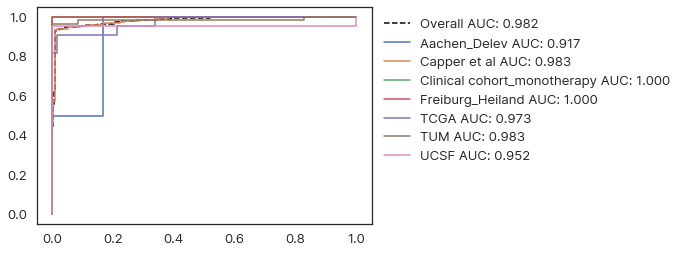

In [41]:
fpr, tpr, thresholds = roc_curve(test_sub.obs.group, test_sub.obs.prediction_score_high, pos_label=1)
auc = roc_auc_score(test_sub.obs.group, test_sub.obs.prediction_score_high)
plt.plot(fpr, tpr, linestyle='--', label='Overall AUC: %.3f' % auc, color="black")

for source in sorted(test.obs.Source.unique()):
    test_source_sub = test_sub[test_sub.obs.Source==source]
    fpr, tpr, thresholds = roc_curve(test_source_sub.obs.group, test_source_sub.obs.prediction_score_high, pos_label=1)
    auc = roc_auc_score(test_source_sub.obs.group, test_source_sub.obs.prediction_score_high)
    plt.plot(fpr, tpr, linestyle='-', label=source+' AUC: %.3f' % auc)

plt.legend(bbox_to_anchor=(1,1), frameon=False)
plt.savefig(os.path.join(savedir, "AUC_thr0.9_allCpG.pdf"), bbox_inches="tight")

In [42]:
clf_report = classification_report(test_sub.obs.group, test_sub.obs.prediction)
print(clf_report)
print("\n")
for source in sorted(test.obs.Source.unique()):
    test_source_sub = test_sub[test_sub.obs.Source==source]
    tmp = test[test.obs.Source==source]
    clf_report = classification_report(test_source_sub.obs.group, test_source_sub.obs.prediction)
    print(source, f"n: {tmp.shape[0]}. Not classified: {tmp.shape[0] - test_source_sub.shape[0]}")
    print(clf_report)
    print("\n")
    

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       371
           1       0.98      0.93      0.96       321

    accuracy                           0.96       692
   macro avg       0.96      0.96      0.96       692
weighted avg       0.96      0.96      0.96       692



Aachen_Delev n: 16. Not classified: 6
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10



Capper et al n: 702. Not classified: 254
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       242
           1       0.99      0.93      0.96       206

    accuracy                           0.96       448
   macro avg       0.97      0.96      0.96  

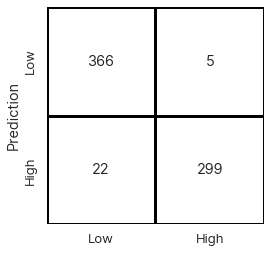

In [43]:
cm = confusion_matrix(test_sub.obs.group, test_sub.obs.prediction)
df_cm = pd.DataFrame(cm, index=["Low", "High"], columns=["Low", "High"])
sns.heatmap(df_cm, annot=True, fmt="d", cmap=ListedColormap(['white']), cbar=False, square=True, linecolor="black", linewidths=1.1)
plt.ylabel("Prediction")
plt.savefig(os.path.join(savedir, "confusion_matrix_thr0.9_allCpG.pdf"), bbox_inches="tight")